<a href="https://colab.research.google.com/github/turtlenoise/hacking_the_kidney/blob/main/hacking_the_kidney.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade --force-reinstall --no-deps albumentations

In [1]:
import os
from PIL import Image
import operator
# from sklearn.model_selection import train_test_split
import numpy as np
import cv2
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [24]:
!ls /content/gdrive/MyDrive/kidney/hubmap*

/content/gdrive/MyDrive/kidney/hubmap-256x256.zip


In [ ]:
!unzip /content/gdrive/MyDrive/kidney/hubmap-256x256.zip

In [6]:
!ls -la ./masks | wc -l

9583


In [12]:
!ls -la ./train | wc -l

9583


In [11]:
# returns a list containing (i,j) coordinates of pixels where glomerulis are found.
def locateGlomeruliPixels(fullPath):
	glomeruliPixels = []

	image = Image.open(fullPath)
	pixelAccess = image.load()

	processedMask = Image.new(image.mode, image.size)
	processedMaskPixels = processedMask.load()
	for i in range(processedMask.size[0]):
	    for j in range(processedMask.size[1]):        
	        if (pixelAccess[i,j] == 1):
	        	processedMaskPixels[i,j] = 256
	        	glomeruliPixels.append((i,j))
	        else:
	        	processedMaskPixels[i,j] = 0        	
	return glomeruliPixels

In [6]:
def visualiseHighlightedGlomeruli(fullPath, glomeruliPixels):
	image = Image.open(fullPath)
	pixelAccess = image.load()

	processedImage = Image.new(image.mode, image.size)
	processedImagePixels = processedImage.load()
	for i in range(processedImage.size[0]):
	    for j in range(processedImage.size[1]):        
	        if ((i,j) not in glomeruliPixels):
	        	# print(pixelAccess[i,j])
	        	processedImagePixels[i,j] = tuple(map(operator.add, pixelAccess[i,j], (-80,-80,-80)))
	        else:
	        	processedImagePixels[i,j] = pixelAccess[i,j]

	return processedImage

./masks/4ef6695ce_0862.png


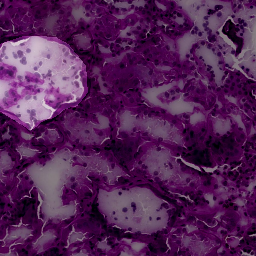

In [14]:
maskDirectoryPath = './masks/'
imageDirectoryPath = './train/'
maskImageName = os.listdir(maskDirectoryPath)[1000]
fullPath = maskDirectoryPath + maskImageName
print(fullPath) 
glomeruliPixels = locateGlomeruliPixels(fullPath)
fullPath = imageDirectoryPath + maskImageName
processedImage = visualiseHighlightedGlomeruli(fullPath, glomeruliPixels)
processedImage

./masks/c68fe75ea_1286.png


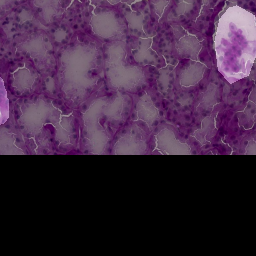

In [19]:
maskImageName = os.listdir(maskDirectoryPath)[2000]
fullPath = maskDirectoryPath + maskImageName
print(fullPath) 
glomeruliPixels = locateGlomeruliPixels(fullPath)
fullPath = imageDirectoryPath + maskImageName
processedImage = visualiseHighlightedGlomeruli(fullPath, glomeruliPixels)
processedImage

In [7]:
def deleteNoGlomeruliImages(directory):
  for filename in os.listdir(directory):
    maskImage = './masks/' + filename
    actualImage = './train/' + filename

    image = Image.open(maskImage)
    pixelAccess = image.load()

    processedMask = Image.new(image.mode, image.size)
    processedMaskPixels = processedMask.load()
    noGlomeruli = True
    for i in range(processedMask.size[0]):
        for j in range(processedMask.size[1]):        
            if (pixelAccess[i,j] == 1):
              noGlomeruli = False
    if (noGlomeruli):
      os.remove(maskImage)
      os.remove(actualImage)

In [8]:
deleteNoGlomeruliImages('./masks/')

In [9]:
!ls -la ./masks | wc -l

3715


In [10]:
!ls -la ./train | wc -l

3715


**Hacking The Kidney**

We can see the glomeruli at the left on the first image and at the top in the second image.
The task is to train a model which can predict from a kidney image whether or not a glomeruli is present or not.

*kidney image inputs -> target glomeruli mask outputs.*

In [11]:
weak_transform = A.Compose([
        A.Resize(256, 256, p=1.0),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9, 
                         border_mode=cv2.BORDER_REFLECT),
        ToTensorV2()
    ], p=1.0)

In [12]:
class HuBMAPDataset(Dataset):
    def __init__(self,df, transform=True):
        ids = df.id.values
        #kf = KFold(n_splits=nfolds,random_state=SEED,shuffle=True)
        #ids = set(ids[list(kf.split(ids))[fold][0 if train else 1]])
        self.fnames = [fname for fname in os.listdir('./train') if fname.split('_')[0] in ids]
        self.transform = transform
        
    def __len__(self):
        return len(self.fnames)
    
    def __getitem__(self, idx):
        fname = self.fnames[idx]
        img = cv2.cvtColor(cv2.imread(os.path.join('./train',fname)), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join('./masks',fname),cv2.IMREAD_GRAYSCALE)
        
        augmented = weak_transform(image=img,mask=mask)
        img,mask = augmented['image'],augmented['mask']
                                
        img = img.type('torch.FloatTensor')
        img = img/255
        mask = mask.type('torch.FloatTensor')

        return img, mask

In [13]:
!unzip /content/gdrive/MyDrive/kidney/train.csv.zip

Archive:  /content/gdrive/MyDrive/kidney/train.csv.zip
  inflating: train.csv               


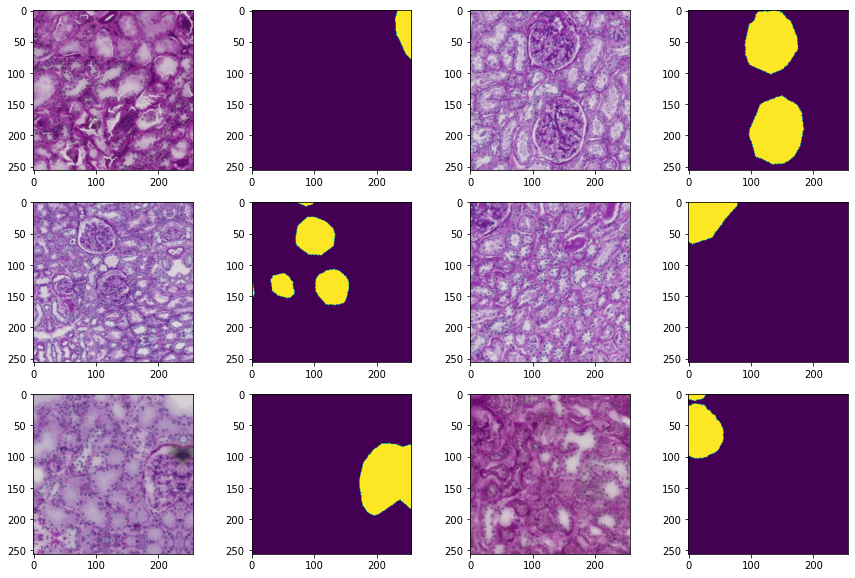

In [14]:
train_df = pd.read_csv('./train.csv')

train_dataset = HuBMAPDataset(train_df, transform=True)
plt.figure(figsize=(15,10))
for i in range(6):
    image, mask = train_dataset[i*9]
    plt.subplot(3,4,2*i+1)
    # (1,2,0) for regaining the original color.
    plt.imshow(np.transpose((image), (1,2,0)))
    plt.subplot(3,4,2*i+2)
    plt.imshow(mask)

In [15]:
image, mask = train_dataset[69]

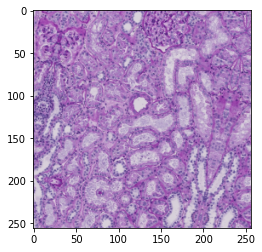

In [21]:
plt.imshow(np.transpose(image,(1,2,0)))

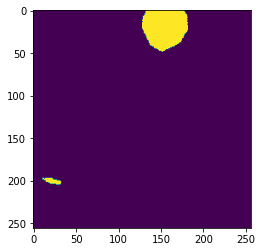

In [17]:
plt.imshow(mask)

In [15]:
batch_size = 12
validation_split = .2
shuffle_dataset = True
random_seed= 42
# Creating data indices for training and validation splits:
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

trainDataLoader = DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validationDataLoader = DataLoader(train_dataset, batch_size=batch_size,
                                                sampler=valid_sampler)


In [16]:
import torch
from torch import nn
# https://arxiv.org/abs/1505.04597
# https://www.nature.com/articles/s41598-019-53797-9
# https://medium.com/analytics-vidhya/creating-a-very-simple-u-net-model-with-pytorch-for-semantic-segmentation-of-satellite-images-223aa216e705
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

In [17]:
xb, yb = next(iter(trainDataLoader))
xb.shape, yb.shape

(torch.Size([12, 3, 256, 256]), torch.Size([12, 256, 256]))

In [18]:
unet = UNET(3,1)
pred = unet(xb)
pred.shape

torch.Size([12, 1, 256, 256])

In [19]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
                
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [20]:
def lossFunc(inputs, targets, smooth=1):
    inputs = inputs.view(-1)
    targets = targets.view(-1)
    
    intersection = (inputs * targets).sum()                            
    dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
    
    return 1 - dice

In [23]:
import time
from IPython.display import clear_output

def train(model, trainDataLoader, validationDataLoader, loss_fn, optimizer, acc_fn, epochs=1):
    start = time.time()
    model.cuda()
    # diceLoss = DiceLoss()

    train_loss, valid_loss = [], []

    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = trainDataLoader
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = validationDataLoader

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                x = x.cuda()
                y = y.cuda()
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = lossFunc(outputs, y)

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = lossFunc(outputs, y.long())

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 

                if step % 100 == 0:
                    # clear_output(wait=True)
                    print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024 ))
                    # print(torch.cuda.memory_summary())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            clear_output(wait=True)
            print('Epoch {}/{}'.format(epoch, epochs - 1))
            print('-' * 10)
            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))
            print('-' * 10)

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.cuda()).float().mean() # yb.cuda()


In [30]:
loss_fn = nn.NLLLoss()
opt = torch.optim.Adam(unet.parameters(), lr=0.01)
train_loss, valid_loss = train(unet, trainDataLoader, validationDataLoader, loss_fn, opt, acc_metric, epochs=60)

Epoch 59/59
----------
valid Loss: 0.1634 Acc: 0.18492718040943146
----------
Training complete in 68m 26s


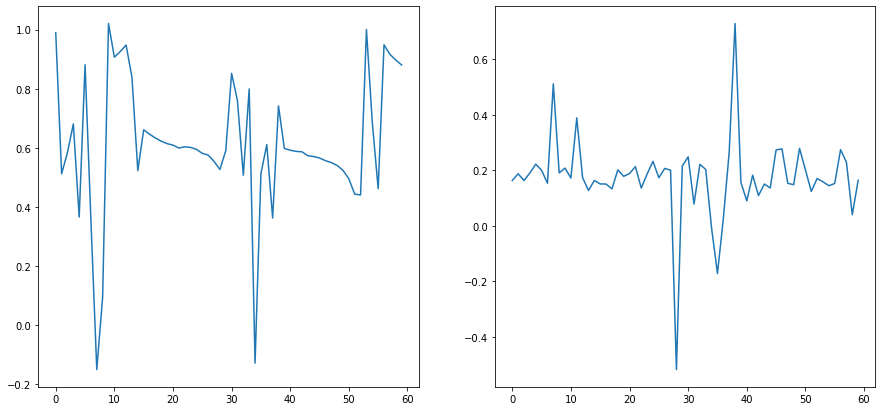

In [31]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
ax[0].plot(train_loss)
ax[1].plot(valid_loss)
plt.show()

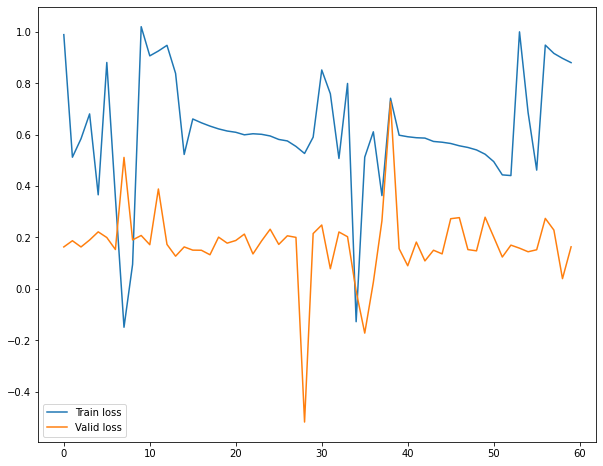

In [32]:
plt.figure(figsize=(10,8))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

In [33]:
def batch_to_img(xb, idx):
    img = np.array(xb[idx,0:3])
    return img.transpose((1,2,0))

def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

In [34]:
xb, yb = next(iter(trainDataLoader))

with torch.no_grad():
    predb = unet(xb.cuda())
    # predb = unet(xb)
predb.shape

torch.Size([12, 1, 256, 256])

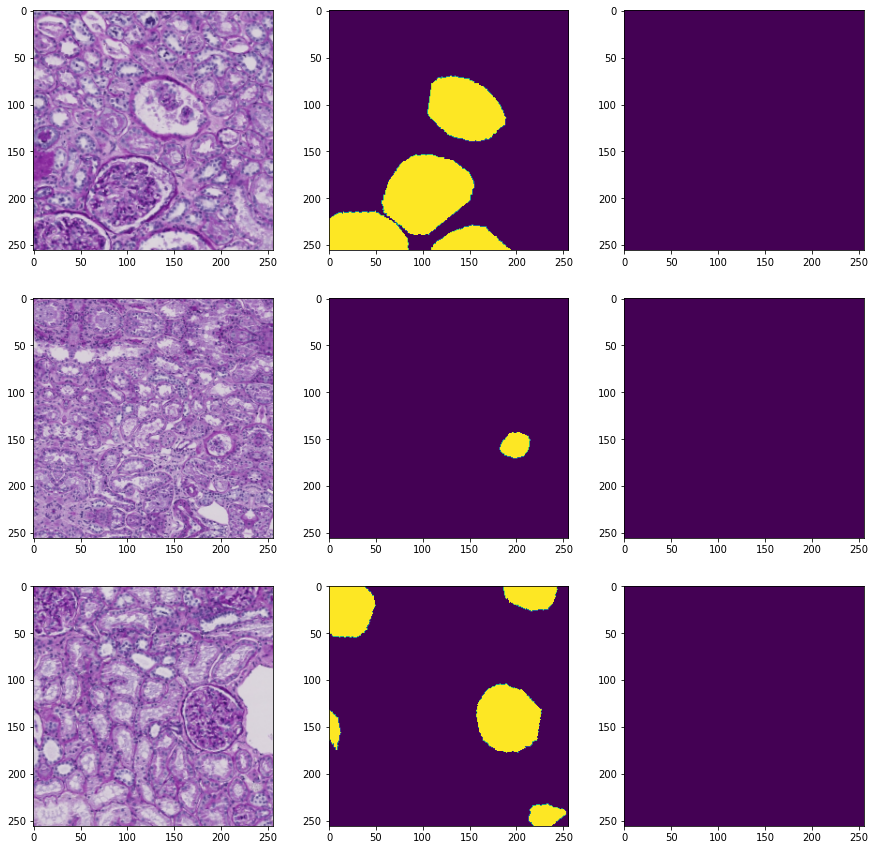

In [35]:
bs = 3
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow((batch_to_img(xb,i)))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))